
=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.80      0.62      0.70       175
           1       0.42      0.64      0.51        75

    accuracy                           0.63       250
   macro avg       0.61      0.63      0.60       250
weighted avg       0.69      0.63      0.64       250

ROC AUC Score: 0.709

=== Random Forest ===
              precision    recall  f1-score   support

           0       0.76      0.89      0.82       175
           1       0.59      0.36      0.45        75

    accuracy                           0.73       250
   macro avg       0.68      0.63      0.63       250
weighted avg       0.71      0.73      0.71       250

ROC AUC Score: 0.768


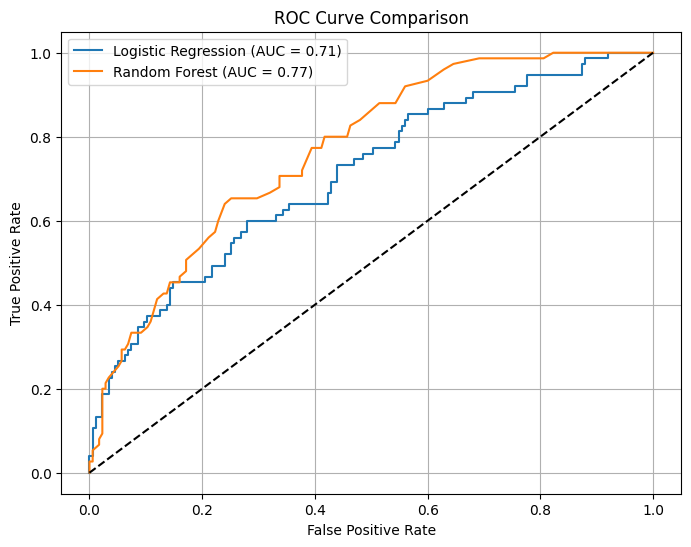

In [ ]:
# 1. Imports
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 2. Load Dataset
data = fetch_openml(data_id=46116, as_frame=True)
X = data.data
y = (data.target == 'bad').astype(int)  # 1 = bad credit risk

# 3. Preprocessing
cat_cols = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
num_cols = ['Duration', 'Credit amount', 'Age']

preprocessor = ColumnTransformer([
    # Categorical features: impute missing with 'missing', then encode
    ('cat', Pipeline([
        ('impute', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
    ]), cat_cols),

    # Numerical features: impute with mean, then scale
    ('num', Pipeline([
        ('impute', SimpleImputer(strategy='mean')),
        ('scale', StandardScaler())
    ]), num_cols)
])

# 4. Pipeline
pipe = Pipeline([
    ('prep', preprocessor)
])
X_processed = pipe.fit_transform(X)

# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.25, random_state=42, stratify=y)

# 6. Train Models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced')
}

for name, model in models.items():
    print(f"\n=== {name} ===")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    proba = model.predict_proba(X_test)[:, 1]
    print(classification_report(y_test, preds))
    print(f"ROC AUC Score: {roc_auc_score(y_test, proba):.3f}")

# 7. Plot ROC Curves
plt.figure(figsize=(8,6))
for name, model in models.items():
    proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, proba):.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()
